In [1]:
import os
import cv2
import random
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
if torch.cuda.is_available() == True:
       device = 'cuda:0'
       print('현재 가상환경 GPU 사용 가능 상태')
else:
       device = 'cpu'
       print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능 상태


In [3]:
def seed_everything(seed: int = 24):
       random.seed(seed)
       np.random.seed(seed)
       # torch.cuda.manual_seed(seed)
       # torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
tot_actions = 5
actions_name = 'backward', 'sit', 'slide', 'swing', 'walk'
min_data_len = 30

In [5]:
actions_csv_dir = '../csv_1214/'
dataset = []

label_mapping = {'backward': 0,
                 'sit': 1,
                 'slide': 2,
                 'swing': 3,
                 'walk' : 4
                 }

def map_action_to_label(csv_name):
       for action, label in label_mapping.items():
              if action in csv_name.split('_')[0]:
                     return label
       return -1

discard_csv = ['swing_10', 'swing_11', 'swing_12']

for action_csv in os.listdir(actions_csv_dir):
       action_df = pd.read_csv(os.path.join(actions_csv_dir, action_csv))
       
       label = map_action_to_label(action_csv)
       if label != -1:
              for idx in range(0, len(action_df), int(min_data_len / 2)):
                     seq_df = action_df[idx: idx + min_data_len] #길이만큼 데이터 자른 것(즉 length 만큼의 프레임)
                     if len(seq_df) == min_data_len: # 딱 length에 개수 맞춰서 끊어서 넣으려고
                            dataset.append({'key': label, 'value': seq_df}) # key에 slide, value에는 묶음 프레임 만큼이 담기겠네
       #최종적으로 dataset에는 행동별로 dictionary 가 만들어져 들어간다.

In [7]:
print(len(dataset[0]['value'].columns)) # z축 까지 99 (33 * 3)차원

75


In [8]:
class MyDataset(Dataset):
       def __init__(self, dataset): #모든 행동을 통합한 df가 들어가야함
              self.x = []
              self.y = []
              for dic in dataset:
                     self.y.append(dic['key']) #key 값에는 actions 들어감
                     self.x.append(dic['value']) #action마다의 data 들어감

       def __getitem__(self, index): #index는 행동의 index
              data = self.x[index] # x에는 꺼내 쓸 (행동마다 45개 묶음프레임)의 데이터
              label = self.y[index]
              return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

       def __len__(self):
              return len(self.x)


In [9]:
train_test_val_ratio = [0.8, 0.1, 0.1]
print(len(dataset))
train_len = int(len(dataset) * train_test_val_ratio[0])
val_len = int(len(dataset) * train_test_val_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

1004
803, 100, 101


In [10]:
CFG = {'batch_size': 32,
       'learning_rate': 1e-3,
       'seed':24,
       'epochs': 100   
}

In [11]:
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=CFG['batch_size'])
val_loader = DataLoader(valid_data, batch_size=CFG['batch_size'])
test_loader = DataLoader(test_data, batch_size=CFG['batch_size'])

In [12]:
class Model1(nn.Module):
       def __init__(self):
              super(Model1, self).__init__()
              self.lstm1 = nn.LSTM(input_size=75, hidden_size=128, num_layers=1, batch_first=True) #input은  45 * 3(x, y z)
              self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
              self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
              self.dropout1 = nn.Dropout(0.1)
              self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
              self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
              self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
              self.dropout2 = nn.Dropout(0.1)
              self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
              self.fc = nn.Linear(32, 5) #분류할 클래스 5가지

       def forward(self, x):
              x, _ = self.lstm1(x)
              x, _ = self.lstm2(x)
              x, _ = self.lstm3(x)
              x = self.dropout1(x)
              x, _ = self.lstm4(x)
              x, _ = self.lstm5(x)
              x, _ = self.lstm6(x)
              x = self.dropout2(x)
              x, _ = self.lstm7(x)
              x = self.fc(x[:, -1, :])
              return x

In [13]:
# Model 2
from torch.autograd import Variable

class ConvLSTMCell(nn.Module):
       def __init__(self, input_channels, hidden_channels, kernel_size):
              super(ConvLSTMCell, self).__init__()

              assert hidden_channels % 2 == 0

              self.input_channels = input_channels
              self.hidden_channels = hidden_channels
              self.kernel_size = kernel_size
              self.num_features = 5

              self.padding = int((kernel_size - 1) / 2)

              self.Wxi = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
              self.Whi = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
              self.Wxf = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
              self.Whf = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
              self.Wxc = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
              self.Whc = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
              self.Wxo = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
              self.Who = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

              self.Wci = None
              self.Wcf = None
              self.Wco = None

       def forward(self, x, h, c):
              ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
              cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
              cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
              co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
              ch = co * torch.tanh(cc)
              return ch

       def init_hidden(self, batch_size, hidden, shape):
              if self.Wci is None:
                     self.Wci = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1]))
                     self.Wcf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1]))
                     self.Wco = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1]))
              else:
                     assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
                     assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
              return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])),
                      Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])))

class Model2(nn.Module):
       def __init__(self):
              super(Model2, self).__init__()
              self.conv_lstm1 = ConvLSTMCell(input_channels=75, hidden_channels=128, kernel_size=5)
              self.conv_lstm2 = ConvLSTMCell(input_channels=128, hidden_channels=256, kernel_size=5)

              self.dropout1 = nn.Dropout(0.1)
              
              self.conv_lstm4 = ConvLSTMCell(input_channels=256, hidden_channels=128, kernel_size=5)
              self.conv_lstm5 = ConvLSTMCell(input_channels=128, hidden_channels=64, kernel_size=5)
              
              self.dropout2 = nn.Dropout(0.1)
              self.conv_lstm6 = ConvLSTMCell(input_channels=64, hidden_channels=32, kernel_size=5)

              self.fc = nn.Linear(32, 5)
              self.step = 10  
              self.num_layers = 6  
              self.effective_step = [9]
           
       def forward(self, x):
              internal_state = []
              outputs = []

              for step in range(self.step):
                     for i in range(self.num_layers):
                            name = 'conv_lstm{}'.format(i + 1)

                            if step == 0:
                                   bsize, _, height, width = x.size()
                                   (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i], shape=(height, width))
                                   internal_state.append((h, c))

                            (h, c) = internal_state[i]
                            x, new_c = getattr(self, name)(x, h, c)
                            internal_state[i] = (x, new_c)

                     if step in self.effective_step:
                            outputs.append(x)

              last_hidden_state = internal_state[-1][0]
              
              output = self.fc(last_hidden_state[:, -1, :])

              return output



In [14]:
import torch.nn.functional as F
import torch.nn.init as init

class Model3(nn.Module):
       def __init__(self):
              super(Model3, self).__init__()

              self.conv = nn.Conv1d(30, 36, 7, 1)
              self.nonLin = nn.BatchNorm1d(30)

              self.recurrent_layer = nn.LSTM(hidden_size=100, input_size=75, bidirectional=True)

              self.recurrent_layer2 = nn.LSTM(hidden_size=100, input_size=200, bidirectional=True)

              self.nonLin2 = nn.BatchNorm1d(200)
              self.activation = nn.LeakyReLU(0.2)  # Leaky ReLU activation
              self.dropout = nn.Dropout(0.5)
              self.classify_layer = nn.Linear(200 * 2, 5)

              # Weight initialization
              init.xavier_uniform_(self.conv.weight)
              init.xavier_uniform_(self.classify_layer.weight)

       def forward(self, input, h_t_1=None, c_t_1=None):
              rnn_outputs, (hn, cn) = self.recurrent_layer(input)
              lin1 = self.nonLin(rnn_outputs)

              rnn_outputs2, (hn2, cn2) = self.recurrent_layer2(lin1)

              lin2 = self.nonLin2(rnn_outputs2)
              conv = self.conv(lin2)
              activation = self.activation(conv)
              activation = activation.permute(0, 2, 1)
              activation = self.dropout(activation)

              flatten = activation.view(activation.size(0), -1)

              logits = self.classify_layer(flatten)
              return logits


In [15]:
import torch.nn.functional as F
import torch.nn.init as init

class Model4(nn.Module):
       def __init__(self):
              super(Model4, self).__init__()

              self.conv = nn.Conv1d(30, 36, 7, 1)
              self.nonLin = nn.BatchNorm1d(30)

              self.recurrent_layer = nn.GRU(hidden_size=100, input_size=75, bidirectional=True)

              self.recurrent_layer2 = nn.GRU(hidden_size=200, input_size=100, bidirectional=True)

              self.nonLin2 = nn.BatchNorm1d(200)
              self.activation = nn.LeakyReLU(0.2)  # Leaky ReLU activation
              self.dropout = nn.Dropout(0.5)
              self.classify_layer = nn.Linear(200 * 2, 5)

              # Weight initialization
              init.xavier_uniform_(self.conv.weight)
              init.xavier_uniform_(self.classify_layer.weight)

       def forward(self, input, h_t_1=None, c_t_1=None):
              rnn_outputs, (hn, cn) = self.recurrent_layer(input)
              lin1 = self.nonLin(rnn_outputs)

              rnn_outputs2, (hn2, cn2) = self.recurrent_layer2(lin1)

              lin2 = self.nonLin2(rnn_outputs2)
              conv = self.conv(lin2)
              activation = self.activation(conv)
              activation = activation.permute(0, 2, 1)
              activation = self.dropout(activation)

              flatten = activation.view(activation.size(0), -1)

              logits = self.classify_layer(flatten)
              return logits


In [16]:
from dev.pytorchtools import EarlyStopping

early_stopping = EarlyStopping(patience=30, verbose=True)

num_epochs = CFG['epochs']
learning_rate = CFG['learning_rate']

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

val_acc_max = 0.75
val_loss_min = float('inf')  # 초기값을 양의 무한대로 설정

lstm = Model1()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=60,
                                                       factor=0.1, min_lr=1e-6, eps=1e-08)

for epoch in range(num_epochs + 1):
       losses = []
       acc_list = []
       lstm.train()
       for i, (input, target) in enumerate(train_loader):
              optimizer.zero_grad()
              outputs = lstm(input)
              loss = criterion(outputs, target.long())
              loss.backward()
              optimizer.step()
              losses.append(loss.item())

              preds = torch.argmax(outputs, dim=1)
              batch_acc = (preds == target).float().mean()
              acc_list.append(batch_acc.item())

       train_losses.append(np.mean(np.array(losses)))
       train_accs.append(np.mean(np.array(acc_list)))

       losses = []
       acc_list = []

       lstm.eval()
       with torch.no_grad():
              correct = 0
              total = 0
              val_loss = 0
              for i, (input, target) in enumerate(val_loader):
                     outputs = lstm(input)
                     _, predicted = torch.max(outputs.data, 1)
                     target = target.long()
                     val_loss += criterion(outputs, target)
                     losses.append(val_loss.item())

                     total += target.size(0)
                     correct += (predicted == target).sum()

              accuracy = 100 * correct / total
              valid_losses.append(np.mean(np.array(losses)))
              valid_accs.append(accuracy.item())

              if epoch % 10 == 0:
                     print("Epoch: %d, loss: %1.5f valid loss: %1.5f lr: %1.5f " %
                           (epoch, train_losses[-1], valid_losses[-1], optimizer.param_groups[0]["lr"]))

              if val_loss_min > valid_losses[-1]:  
                     val_loss_min = valid_losses[-1]
                     torch.save(lstm, fr'C:\Users\USER\Desktop\19rne\2023-RnE-main\save_by_loss\model_.pth')

              scheduler.step(valid_losses[-1])

              early_stopping(round(valid_losses[-1], 5), lstm)

              if early_stopping.early_stop:
                     print("Epoch: %d, loss: %1.5f valid loss: %1.5f lr: %1.5f " %
                           (epoch, train_losses[-1], valid_losses[-1], optimizer.param_groups[0]["lr"]))
                     break


Epoch: 0, loss: 1.66451 valid loss: 4.09086 lr: 0.00100 
Validation loss decreased (inf --> 4.090860).  Saving model ...
Validation loss decreased (4.090860 --> 3.964100).  Saving model ...
Validation loss decreased (3.964100 --> 3.852710).  Saving model ...
Validation loss decreased (3.852710 --> 3.756910).  Saving model ...
Validation loss decreased (3.756910 --> 3.674700).  Saving model ...
Validation loss decreased (3.674700 --> 3.604240).  Saving model ...
Validation loss decreased (3.604240 --> 3.544010).  Saving model ...
Validation loss decreased (3.544010 --> 3.492640).  Saving model ...
Validation loss decreased (3.492640 --> 3.448920).  Saving model ...
Validation loss decreased (3.448920 --> 3.411840).  Saving model ...
Epoch: 10, loss: 1.36830 valid loss: 3.38043 lr: 0.00100 
Validation loss decreased (3.411840 --> 3.380430).  Saving model ...
Validation loss decreased (3.380430 --> 3.353870).  Saving model ...
Validation loss decreased (3.353870 --> 3.331410).  Saving mod

In [17]:
print(train_losses, valid_losses, train_accs, valid_accs)

[1.6645072927841773, 1.6160603761672974, 1.5690331825843225, 1.5281135990069463, 1.4931477308273315, 1.4632783302894006, 1.437547967984126, 1.4158186545738807, 1.3972229636632478, 1.381659759924962, 1.3682966690797072, 1.3570995514209454, 1.3477443548349233, 1.3398027007396405, 1.332908048079564, 1.3272519340881934, 1.322229816363408, 1.3183267712593079, 1.3146007565351634, 1.3116262142474835, 1.309016580765064, 1.3065645419634306, 1.3046945287631109, 1.3028130072813768, 1.3014338337458098, 1.299690374961266, 1.298569454596593, 1.2972084375528188, 1.296171206694383, 1.2949942854734569, 1.2943815497251658, 1.293615698814392, 1.292873345888578, 1.2920041175989003, 1.2915958853868337, 1.2907948264708886, 1.2904181021910448, 1.289965244439932, 1.289464024397043, 1.2891363226450407, 1.2888218210293696, 1.2884404796820421, 1.2882084158750682, 1.2879399886498084, 1.2874946089891286, 1.2874214695050166, 1.2871180039185743, 1.2869252195725074, 1.2867666941422682, 1.2865648819850042, 1.286604055

In [22]:
res = [[1.6645072927841773, 1.6160603761672974, 1.5690331825843225, 1.5281135990069463, 1.4931477308273315, 1.4632783302894006, 1.437547967984126, 1.4158186545738807, 1.3972229636632478, 1.381659759924962, 1.3682966690797072, 1.3570995514209454, 1.3477443548349233, 1.3398027007396405, 1.332908048079564, 1.3272519340881934, 1.322229816363408, 1.3183267712593079, 1.3146007565351634, 1.3116262142474835, 1.309016580765064, 1.3065645419634306, 1.3046945287631109, 1.3028130072813768, 1.3014338337458098, 1.299690374961266, 1.298569454596593, 1.2972084375528188, 1.296171206694383, 1.2949942854734569, 1.2943815497251658, 1.293615698814392, 1.292873345888578, 1.2920041175989003, 1.2915958853868337, 1.2907948264708886, 1.2904181021910448, 1.289965244439932, 1.289464024397043, 1.2891363226450407, 1.2888218210293696, 1.2884404796820421, 1.2882084158750682, 1.2879399886498084, 1.2874946089891286, 1.2874214695050166, 1.2871180039185743, 1.2869252195725074, 1.2867666941422682, 1.2865648819850042, 1.2866040559915395, 1.2863171054766729, 1.2863825605465815, 1.2859925719407888, 1.2858293469135578, 1.2857366937857408, 1.2858472237220178, 1.2856693680469806, 1.2851948967346778, 1.2853522392419667, 1.2851463372890766, 1.2851203404940093, 1.2852068084936876, 1.2850808409544139, 1.2850570174363942, 1.2848643935643709, 1.284759636108692, 1.2847790534679706, 1.284824325488164, 1.2847741108674269, 1.2844424018493066, 1.2845483834926898, 1.2846238315105438, 1.2843253772992353, 1.2843242448109846, 1.2842233777046204, 1.2845360132364125, 1.2841830941346974, 1.2845137119293213, 1.2843562914774969, 1.2841233679881463, 1.2842514285674462, 1.284220509804212, 1.2841655543217292, 1.2843667199978461] [4.090862214565277, 3.964098572731018, 3.852714091539383, 3.7569140791893005, 3.6746982038021088, 3.6042402386665344, 3.544006198644638, 3.4926357865333557, 3.448920786380768, 3.4118373692035675, 3.3804314732551575, 3.353868752717972, 3.3314106166362762, 3.3123838007450104, 3.296239912509918, 3.282495230436325, 3.2707569301128387, 3.260680377483368, 3.2520035803318024, 3.2444784939289093, 3.2379291355609894, 3.232205718755722, 3.2271696627140045, 3.222735345363617, 3.2187981605529785, 3.215308129787445, 3.212197184562683, 3.2094317972660065, 3.206957906484604, 3.204738438129425, 3.2027608454227448, 3.200996845960617, 3.1994248926639557, 3.198022186756134, 3.1967703104019165, 3.1956611573696136, 3.1946721971035004, 3.1937944293022156, 3.193017363548279, 3.1923393607139587, 3.1917509138584137, 3.1912316977977753, 3.1907759308815002, 3.19038850069046, 3.190050482749939, 3.189771205186844, 3.189537525177002, 3.189339339733124, 3.1891814172267914, 3.1890613734722137, 3.18897345662117, 3.1889072358608246, 3.1888664066791534, 3.1888466477394104, 3.1888527274131775, 3.1888833343982697, 3.1889193058013916, 3.188969135284424, 3.189032018184662, 3.189104199409485, 3.1891914308071136, 3.189284026622772, 3.1893858313560486, 3.1894978880882263, 3.1896104216575623, 3.189728409051895, 3.1898582577705383, 3.1899873316287994, 3.1901169419288635, 3.190248131752014, 3.1903818249702454, 3.1905190646648407, 3.1906570196151733, 3.1908005475997925, 3.1909464299678802, 3.1910910606384277, 3.191228300333023, 3.191367268562317, 3.1915021538734436, 3.191645920276642, 3.1917780339717865, 3.1919074058532715, 3.1920455992221832, 3.192184418439865, 3.1923215091228485] [0.03485576923076923, 0.03485576923076923, 0.43589743627951694, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015, 0.5080128208949015] [4.0, 4.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]]


<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
C:\Users\USER\AppData\Local\Temp\ipykernel_1752\459484574.py:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  res = [[1.6645072927841773, 1.6160603761672974, 1.5690331825843225, 1.5281135990069463, 1.4931477308273315, 1.4632783302894006, 1.437547967984126, 1.4158186545738807, 1.3972229636632478, 1.381659759924962, 1.3682966690797072, 1.3570995514209454, 1.3477443548349233, 1.3398027007396405, 1.332908048079564, 1.3272519340881934, 1.322229816363408, 1.3183267712593079, 1.3146007565351634, 1.3116262142474835, 1.309016580765064, 1.3065645419634306, 1.3046945287631109, 1.3028130072813768, 1.3014338337458098, 1.299690374961266, 1.298569454596593, 1.2972084375528188, 1.296171206694383, 1.2949942854734569, 1.2943815497251658, 1.293615698814392

TypeError: list indices must be integers or slices, not tuple

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(train_accs, label='Training Accuracy')
# plt.plot(valid_accs, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy over Epochs')
# plt.legend()
# plt.show()


OrderedDict([('lstm1.weight_ih_l0', tensor([[ 0.0106,  0.0242, -0.0078,  ...,  0.0666, -0.0148, -0.0841],
        [-0.0231, -0.0550,  0.0528,  ...,  0.0713, -0.0040, -0.0330],
        [ 0.0231,  0.0690,  0.0860,  ...,  0.0452,  0.0325,  0.0387],
        ...,
        [ 0.0411, -0.0150,  0.0160,  ...,  0.0471, -0.0437, -0.0269],
        [ 0.0147, -0.0360, -0.0769,  ..., -0.0176, -0.0588, -0.0270],
        [-0.0545,  0.0651,  0.0564,  ..., -0.0187,  0.0805, -0.0175]])), ('lstm1.weight_hh_l0', tensor([[ 0.0696, -0.0242,  0.0037,  ...,  0.0748, -0.0340,  0.0232],
        [-0.0830,  0.0406, -0.0691,  ..., -0.0431, -0.0609, -0.0500],
        [ 0.0299,  0.0226,  0.0513,  ...,  0.0128,  0.0134,  0.0247],
        ...,
        [-0.0672,  0.0084, -0.0638,  ..., -0.0733, -0.0641, -0.0737],
        [ 0.0594,  0.0357,  0.0599,  ...,  0.0397, -0.0346, -0.0428],
        [-0.0431,  0.0424, -0.0633,  ..., -0.0643,  0.0663,  0.0109]])), ('lstm1.bias_ih_l0', tensor([-0.0511, -0.0311, -0.0554,  0.0446,  0.0

RuntimeError: a Tensor with 160 elements cannot be converted to Scalar

85 85


ValueError: x and y must have same first dimension, but have shapes (86,) and (85,)

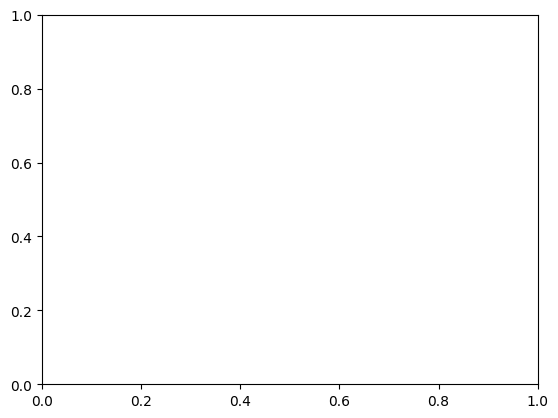

In [30]:
import matplotlib.pyplot as plt

# 주어진 데이터
train_loss = [1.6645072927841773, 1.6160603761672974, 1.5690331825843225, 1.5281135990069463, 1.4931477308273315, 1.4632783302894006, 1.437547967984126, 1.4158186545738807, 1.3972229636632478, 1.381659759924962, 1.3682966690797072, 1.3570995514209454, 1.3477443548349233, 1.3398027007396405, 1.332908048079564, 1.3272519340881934, 1.322229816363408, 1.3183267712593079, 1.3146007565351634, 1.3116262142474835, 1.309016580765064, 1.3065645419634306, 1.3046945287631109, 1.3028130072813768, 1.3014338337458098, 1.299690374961266, 1.298569454596593, 1.2972084375528188, 1.296171206694383, 1.2949942854734569, 1.2943815497251658, 1.293615698814392, 1.292873345888578, 1.2920041175989003, 1.2915958853868337, 1.2907948264708886, 1.2904181021910448, 1.289965244439932, 1.289464024397043, 1.2891363226450407, 1.2888218210293696, 1.2884404796820421, 1.2882084158750682, 1.2879399886498084, 1.2874946089891286, 1.2874214695050166, 1.2871180039185743, 1.2869252195725074, 1.2867666941422682, 1.2865648819850042, 1.2866040559915395, 1.2863171054766729, 1.2863825605465815, 1.2859925719407888, 1.2858293469135578, 1.2857366937857408, 1.2858472237220178, 1.2856693680469806, 1.2851948967346778, 1.2853522392419667, 1.2851463372890766, 1.2851203404940093, 1.2852068084936876, 1.2850808409544139, 1.2850570174363942, 1.2848643935643709, 1.284759636108692, 1.2847790534679706, 1.284824325488164, 1.2847741108674269, 1.2844424018493066, 1.2845483834926898, 1.2846238315105438, 1.2843253772992353, 1.2843242448109846, 1.2842233777046204, 1.2845360132364125, 1.2841830941346974, 1.2845137119293213, 1.2843562914774969, 1.2841233679881463, 1.2842514285674462, 1.284220509804212, 1.2841655543217292, 1.2843667199978461]  # train loss 데이터
valid_loss = [4.090862214565277, 3.964098572731018, 3.852714091539383, 3.7569140791893005, 3.6746982038021088, 3.6042402386665344, 3.544006198644638, 3.4926357865333557, 3.448920786380768, 3.4118373692035675, 3.3804314732551575, 3.353868752717972, 3.3314106166362762, 3.3123838007450104, 3.296239912509918, 3.282495230436325, 3.2707569301128387, 3.260680377483368, 3.2520035803318024, 3.2444784939289093, 3.2379291355609894, 3.232205718755722, 3.2271696627140045, 3.222735345363617, 3.2187981605529785, 3.215308129787445, 3.212197184562683, 3.2094317972660065, 3.206957906484604, 3.204738438129425, 3.2027608454227448, 3.200996845960617, 3.1994248926639557, 3.198022186756134, 3.1967703104019165, 3.1956611573696136, 3.1946721971035004, 3.1937944293022156, 3.193017363548279, 3.1923393607139587, 3.1917509138584137, 3.1912316977977753, 3.1907759308815002, 3.19038850069046, 3.190050482749939, 3.189771205186844, 3.189537525177002, 3.189339339733124, 3.1891814172267914, 3.1890613734722137, 3.18897345662117, 3.1889072358608246, 3.1888664066791534, 3.1888466477394104, 3.1888527274131775, 3.1888833343982697, 3.1889193058013916, 3.188969135284424, 3.189032018184662, 3.189104199409485, 3.1891914308071136, 3.189284026622772, 3.1893858313560486, 3.1894978880882263, 3.1896104216575623, 3.189728409051895, 3.1898582577705383, 3.1899873316287994, 3.1901169419288635, 3.190248131752014, 3.1903818249702454, 3.1905190646648407, 3.1906570196151733, 3.1908005475997925, 3.1909464299678802, 3.1910910606384277, 3.191228300333023, 3.191367268562317, 3.1915021538734436, 3.191645920276642, 3.1917780339717865, 3.1919074058532715, 3.1920455992221832, 3.192184418439865, 3.1923215091228485]   # validation loss 데이터


# 그래프 그리기
epochs = range(len(train_loss) + 1)
print(len(train_loss), len(valid_loss))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
